In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

from source_code.SqlCo import Sqldd

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled
Local Sec Env loaded


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## you can dl csv data with link and replace this code for pd.red_csv()
tip = Sqldd()
cnx, cursor = tip.get_bdd_co()
df = pd.read_sql(f"SELECT * FROM cov_baseline;", con=cnx) 

In [3]:
df.head(3)

,id,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,1,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
1,2,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
2,3,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,id,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
54242,56124,ZWE,Africa,Zimbabwe,2020-11-03,8389.0,15.0,12.286,245.0,2.0,...,0.0,0.0,0.0,1.486290e+07,42.729,19.6,2.822,1.882,1899.78,21.4
54243,56125,OWID_WRL,Null,World,2020-11-03,47093200.0,434586.0,492851.000,1207290.0,5654.0,...,0.0,0.0,0.0,7.794800e+09,58.045,30.9,8.696,5.355,15469.20,10.0
54244,56126,Null,Null,International,2020-11-03,696.0,0.0,0.000,7.0,0.0,...,0.0,0.0,0.0,0.000000e+00,0.000,0.0,0.000,0.000,0.00,0.0


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


WARNING - No handles with labels found to put in legend.


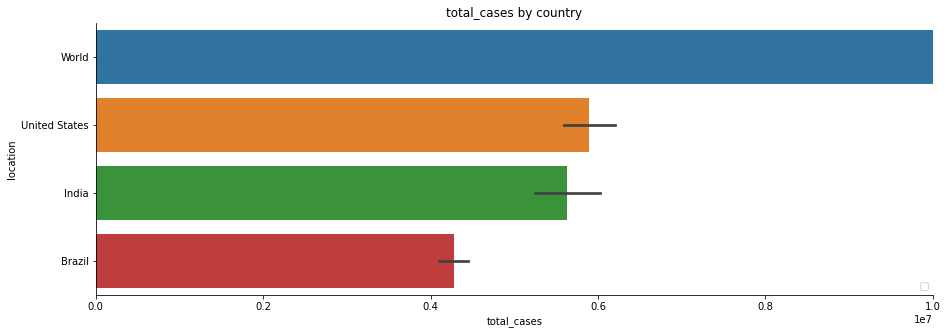

In [13]:
worldrep("total_cases",graph_long=5,val_larg=10000000)

WARNING - No handles with labels found to put in legend.


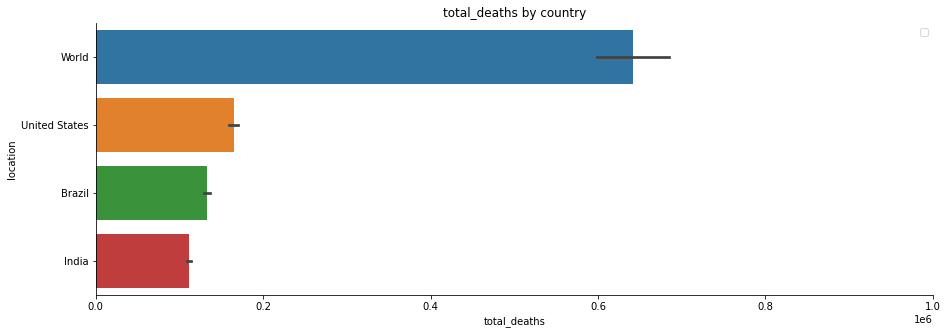

In [14]:
worldrep("total_deaths",val_larg=1000000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

WARNING - No handles with labels found to put in legend.


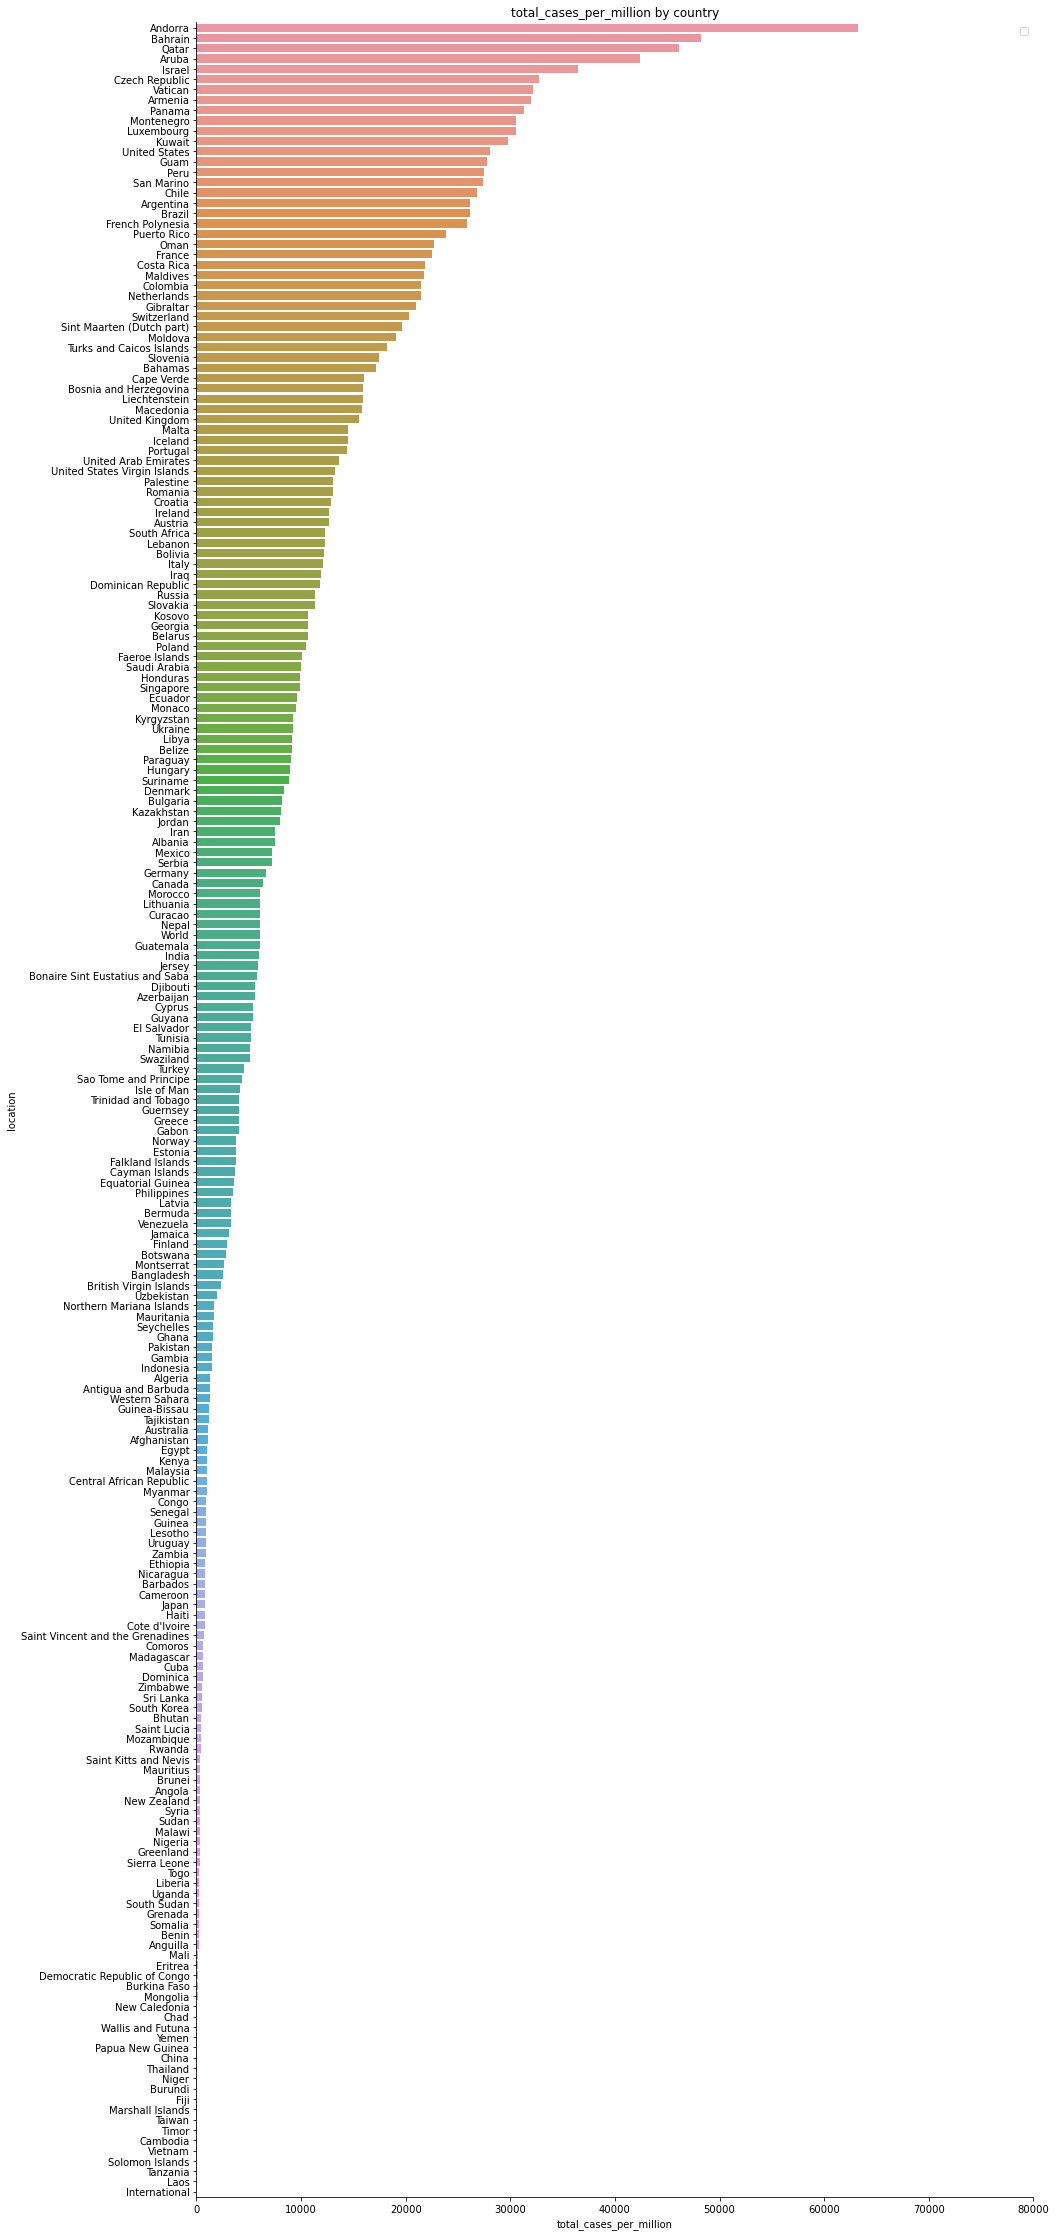

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=80000,df=dds)
except:
    print("Not today")

WARNING - No handles with labels found to put in legend.


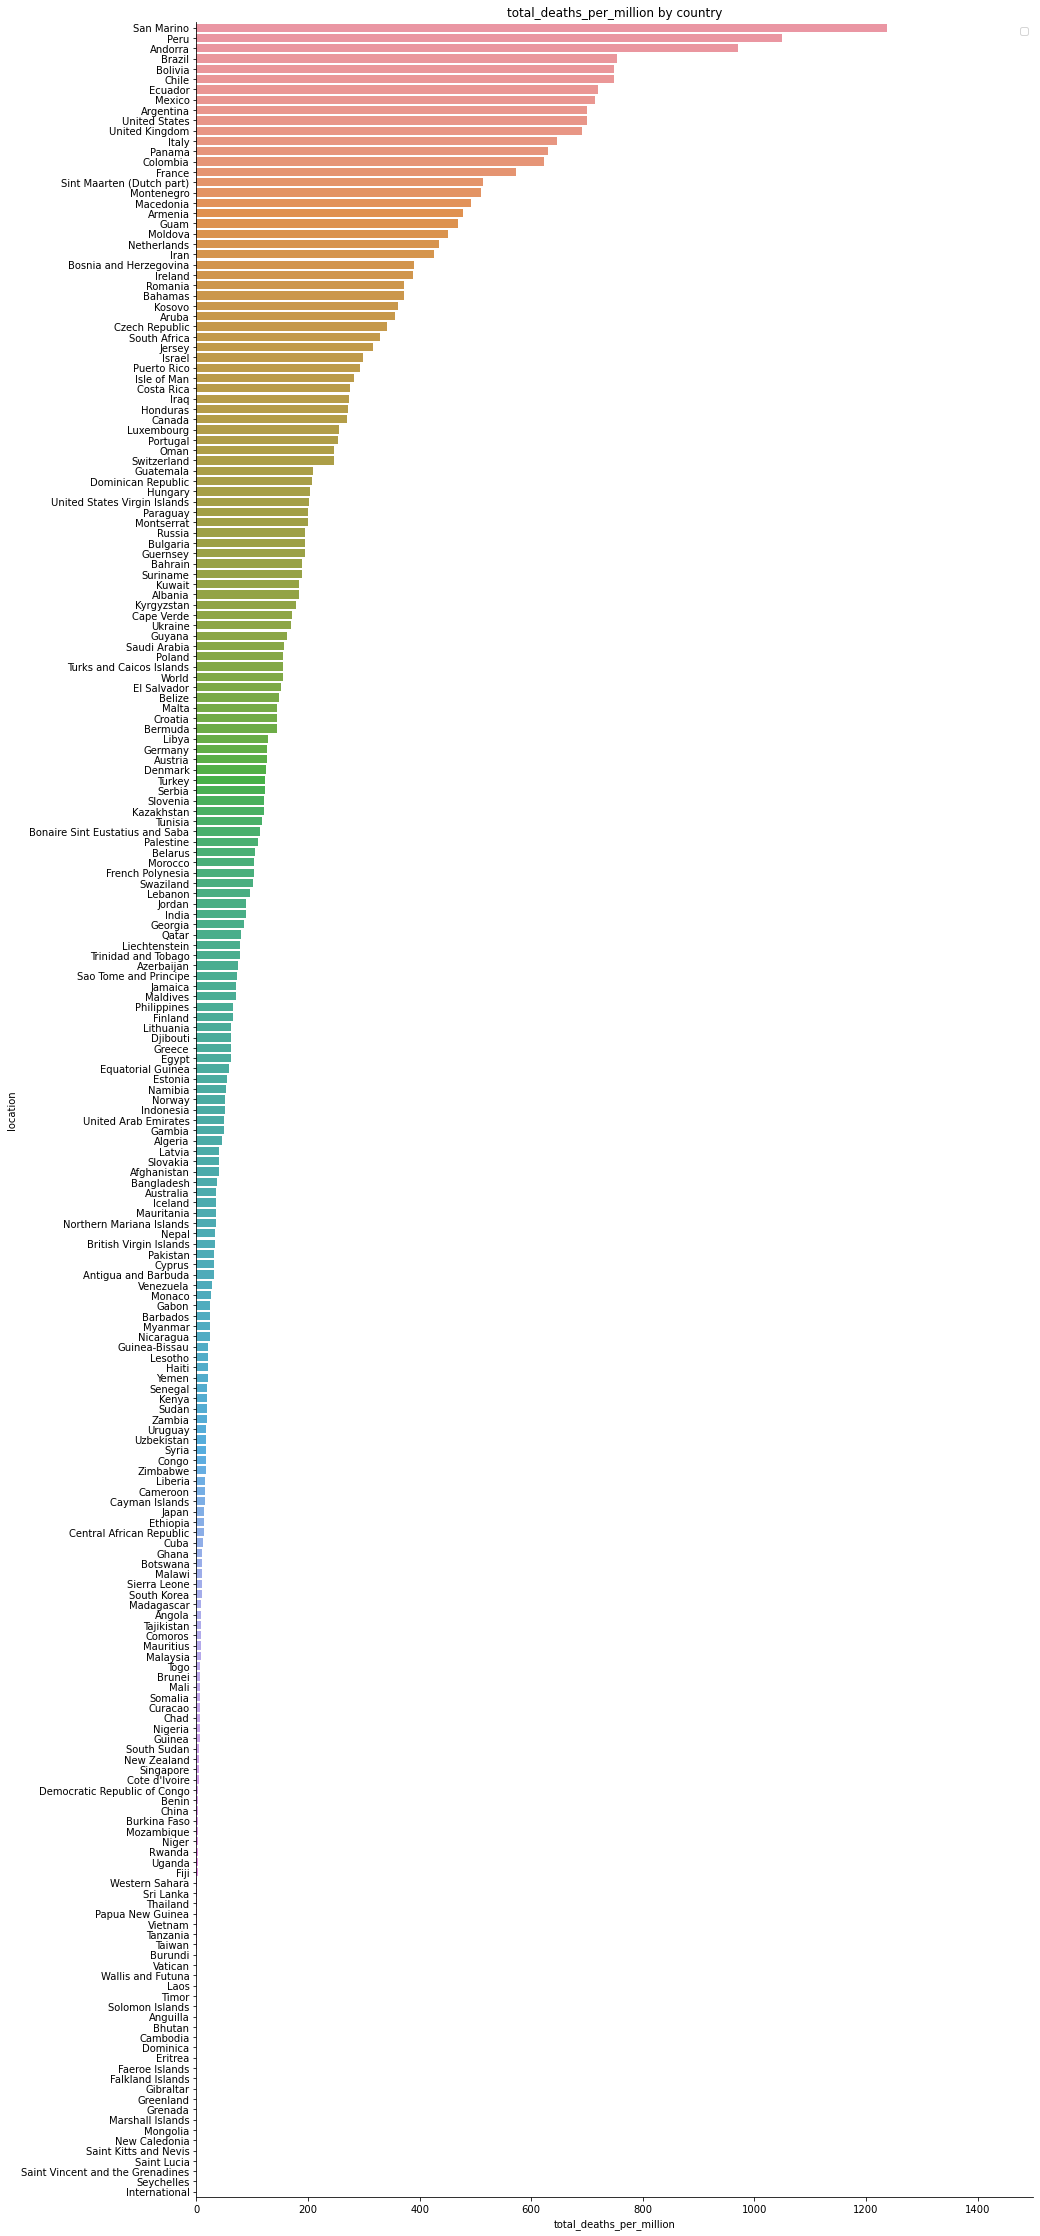

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

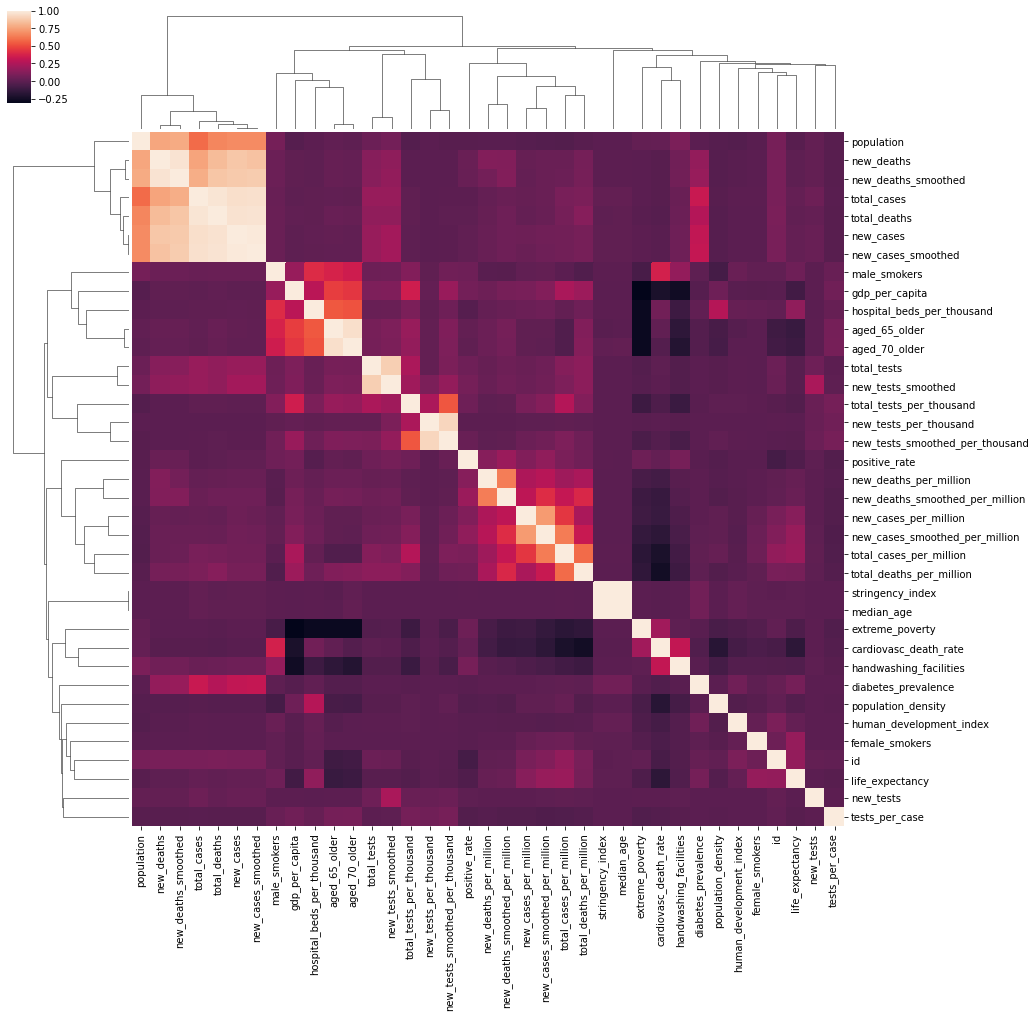

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(df,subject,periode,country,n_splits=3,max_iter=5000):

    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(df,subject,periode,country):
    vals, x_train, y_train, model = createModel(df,subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine(df,"total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine(df,"total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9981988248932475 (+/- 0.0019965683855119667)
Coef :  [1.02829768e+00 4.80802205e-05 4.98592928e-05]
3 Last_days :  [[46156500 46597300 47093200]]
Today :  47093200
Prediction + :  492873
Tomorow :  47586073
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993037782283509 (+/- 0.0005145507743836048)
Coef :  [0.45815968 0.26793846 0.28333159]
3 Last_days :  [[1196270 1201160 1207290]]
Today :  1207290
Prediction + :  9176
Tomorow :  1216466
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9803256698055881 (+/- 0.02466343137996677)
Coef :  [-0.45619683  0.58051975  0.89794269]
3 Last_days :  [[1364620 1413920 1466430]]
Today :  1466430
Prediction + :  47132
Tomorow :  1513562
                                     
--------- Total Death -----------------
                                     
R^2: 0.6963502680741268 (+/- 0.42383968961154994)
Coef :  [-0.73183704  0.78169219  0.94944725]
3 Last_days :  [[36788 37019 37435]]
Today :  37435
Prediction + :  176
Tomorow :  37611
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9804610652404779 (+/- 0.026922778194904278)
Coef :  [-0.3382024   0.00460444  1.32787689]
3 Last_days :  [[91323 91347 91396]]
Today :  91396
Prediction + :  28
Tomorow :  91424
                                     
--------- Total Death -----------------
                                     
R^2: 0.6683942418414425 (+/- 0.17574795060624032)
Coef :  [-0.07859445  0.01256212  1.05744885]
3 Last_days :  [[4739 4739 4739]]
Today :  4739
Prediction + :  4
Tomorow :  4743
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9869761514237227 (+/- 0.016877410167312774)
Coef :  [-0.98295743  0.97395873  1.01089209]
3 Last_days :  [[679430 709335 731588]]
Today :  731588
Prediction + :  30806
Tomorow :  762394
                                     
--------- Total Death -----------------
                                     
R^2: 0.992332746787964 (+/- 0.004850712912219496)
Coef :  [-0.80432826  0.88773261  0.91562751]
3 Last_days :  [[38618 38826 39059]]
Today :  39059
Prediction + :  169
Tomorow :  39228
                                     


In [28]:
last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Belgium")
spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp

********* For Belgium **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9497876277919634 (+/- 0.06801581800971632)
Coef :  [-0.74778184  0.58715264  1.16246875]
3 Last_days :  [[156838 162165 165787]]
Today :  165787
Prediction + :  4859
Tomorow :  170646
                                     
--------- Total Death -----------------
                                     
R^2: 0.5124371067252302 (+/- 0.6875715671999193)
Coef :  [-0.86375074  0.9242948   0.93854233]
3 Last_days :  [[10175 10191 10211]]
Today :  10211
Prediction + :  16
Tomorow :  10227
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9730368298424885 (+/- 0.035003773580288486)
Coef :  [0.43472871 0.28717598 0.29223055]
3 Last_days :  [[9126360 9207360 9291240]]
Today :  9291240
Prediction + :  60539
Tomorow :  9351779
                                     
--------- Total Death -----------------
                                     
R^2: 0.7183056348120682 (+/- 0.3971090481156579)
Coef :  [-0.14974132  0.55496324  0.59743293]
3 Last_days :  [[230556 230996 231551]]
Today :  231551
Prediction + :  1148
Tomorow :  232699
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9851045164090544 (+/- 0.020149718948098534)
Coef :  [-0.84824354  0.90962198  0.94338273]
3 Last_days :  [[1011660 1034910 1053860]]
Today :  1053860
Prediction + :  23304
Tomorow :  1077164
                                     
--------- Total Death -----------------
                                     
R^2: 0.7634236043501555 (+/- 0.3238989595173565)
Coef :  [-0.74425426  0.82198516  0.92155893]
3 Last_days :  [[46555 46717 46853]]
Today :  46853
Prediction + :  146
Tomorow :  46999
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: -2.9789967575425944 (+/- 5.625935680573612)
Coef :  [-0.87866955  0.89663716  0.98471889]
3 Last_days :  [[532930 545027 560379]]
Today :  560379
Prediction + :  11763
Tomorow :  572142
                                     
--------- Total Death -----------------
                                     
R^2: 0.19223140120164386 (+/- 1.1345677613451626)
Coef :  [-0.7645744   0.82963581  0.93429696]
3 Last_days :  [[10481 10530 10661]]
Today :  10661
Prediction + :  36
Tomorow :  10697
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995643017636756 (+/- 0.00024623658818966087)
Coef :  [0.471055   0.27196306 0.27302126]
3 Last_days :  [[612772 620491 628780]]
Today :  628780
Prediction + :  1625
Tomorow :  630405
                                     
--------- Total Death -----------------
                                     
R^2: 0.9796480795397858 (+/- 0.028071552133890926)
Coef :  [0.44685349 0.28776105 0.28170539]
3 Last_days :  [[34864 35298 35738]]
Today :  35738
Prediction + :  138
Tomorow :  35876
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9997526089456475 (+/- 9.277603434861763e-05)
Coef :  [-0.3541886   0.66872178  0.68360306]
3 Last_days :  [[375367 377473 379775]]
Today :  379775
Prediction + :  1263
Tomorow :  381038
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996550540511104 (+/- 1.7819017730564314e-05)
Coef :  [-0.71534832  0.85257645  0.86268214]
3 Last_days :  [[10252 10326 10402]]
Today :  10402
Prediction + :  61
Tomorow :  10463
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7425663271213829 (+/- 0.35448424007729484)
Coef :  [0.01240306 0.46462404 0.53119482]
3 Last_days :  [[5535600 5545700 5554210]]
Today :  5554210
Prediction + :  55030
Tomorow :  5609240
                                     
--------- Total Death -----------------
                                     
R^2: 0.39034054314682304 (+/- 0.8549855198108162)
Coef :  [0.0871809  0.43684254 0.48259988]
3 Last_days :  [[159884 160074 160253]]
Today :  160253
Prediction + :  1436
Tomorow :  161689
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(47093200, 1207290, 47586073, 1216466),
 (1466430, 37435, 1513562, 37611),
 (731588, 39059, 762394, 39228),
 (165787, 10211, 170646, 10227),
 (9291240, 231551, 9351779, 232699),
 (91396, 4739, 91424, 4743),
 (1053860, 46853, 1077164, 46999),
 (560379, 10661, 572142, 10697),
 (628780, 35738, 630405, 35876),
 (379775, 10402, 381038, 10463),
 (5554210, 160253, 5609240, 161689)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()
    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    return pop_pred

In [43]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Belgium",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-11-03,France,1513562.0,0.0,37611.0,0.0,0.0,0.0
0,2020-11-03,China,91424.0,0.0,4743.0,0.0,0.0,0.0
0,2020-11-03,Italy,762394.0,0.0,39228.0,0.0,0.0,0.0
0,2020-11-03,Belgium,170646.0,0.0,10227.0,0.0,0.0,0.0
0,2020-11-03,United States,9351779.0,0.0,232699.0,0.0,0.0,0.0
0,2020-11-03,World,47586073.0,0.0,1216466.0,0.0,0.0,0.0
0,2020-11-03,United Kingdom,1077164.0,0.0,46999.0,0.0,0.0,0.0
0,2020-11-03,Germany,572142.0,0.0,10697.0,0.0,0.0,0.0
0,2020-11-03,Iran,630405.0,0.0,35876.0,0.0,0.0,0.0
0,2020-11-03,Turkey,381038.0,0.0,10463.0,0.0,0.0,0.0


In [41]:
#predpred.to_csv(f"data\\Pred\\predDf{date.today()}.csv")

In [42]:
pre_pred_tobdd = predpred.drop(columns=['total_cases_real','total_deaths_real','error_abs_cases','error_abs_deaths'])
pre_pred_tobdd

,date,country,total_cases_predict,total_deaths_predict
0,2020-11-03,France,1513562.0,37611.0
0,2020-11-03,China,91424.0,4743.0
0,2020-11-03,Italy,762394.0,39228.0
0,2020-11-03,Spain,170646.0,10227.0
0,2020-11-03,United States,9351779.0,232699.0
0,2020-11-03,World,47586073.0,1216466.0
0,2020-11-03,United Kingdom,1077164.0,46999.0
0,2020-11-03,Germany,572142.0,10697.0
0,2020-11-03,Iran,630405.0,35876.0
0,2020-11-03,Turkey,381038.0,10463.0


In [46]:
df_pop_pred4

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-11-03,Belgium,170646.0,0.0,10227.0,0.0,0.0,0.0


In [52]:
#from source_code.backpip import data_up_pip
# try:
#     data_job = data_up_pip(pre_pred_tobdd) 
#     data_job.up_pred()
#     data_job.clean_leave()
# except:
#     print("BDD job Failed -- Normal if you not have acces to main code")

 Insert Prediction Done !! 
